In [15]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import time

In [16]:
# Define constants
mean = 1/2
sd = 1/6
kmax = 400      # Number of cells
zrange = np.linspace(0,1,kmax)  #Array of evenly spaced numbers 0-1
eps0 = 8.854187812813e-12 # Permittivity of free space
mu0 = 1.2566370621219e-6  # Permeability of free space
c0 = round(1/np.sqrt(mu0*eps0)) # Speed of light in free space
deltaz = 1     # Cell width
deltat = deltaz/(2*c0) # Time step
tprop = kmax*2    # Time taken for wave to propagate across full system with no material
T = int(np.ceil(5*len(zrange) + 10*tprop)) # Total time of simulation
MaterialLength = 50    # Length of material used
kMat = 200           # Left-most cell of material
#opnmax = 50    # Maximum optical density

In [17]:
#Calculate Permittivity tensor for Gaussian surface
x,y,z,sx,sy,s= symbols('x y z sx sy s') # Defining symbols for sympy calculations

xp = x                     # Coordinate transformation for Gaussian surface
yp = y
zp = z*(1-exp(-z**2/s**2))

L2 = Matrix([[diff(xp,x),diff(xp,y),diff(xp,z)],[diff(yp,x),diff(yp,y),diff(yp,z)],[diff(zp,x),diff(zp,y),diff(zp,z)]]) # Calculating Lambda matrix dx'/dx
L2 = simplify(L2,rational = True)

g = Matrix([[1,0,0],[0,1,0],[0,0,1]]) # Metric tensor of original coordinates (Minkowski)
L1 = simplify(L2.inv())         # dx/dx'
gp = simplify(transpose(L1))*g*L1  # New metric tensor
gpdet = gp.det()              #Determinant
eps = simplify(sqrt(1/gpdet))*simplify(gp) # Permittivity tensor

In [18]:
eps = eps.subs(s,0.25) # Substitute value for sigma

In [19]:
# constant permittivity tensor in the medium

# x,y,z,sx,sy,s= symbols('x y z sx sy s')

# xp = x           # Simpler transformation
# yp = y
# zp = z/4

# L2 = Matrix([[diff(xp,x),diff(xp,y),diff(xp,z)],[diff(yp,x),diff(yp,y),diff(yp,z)],[diff(zp,x),diff(zp,y),diff(zp,z)]])
# L2 = simplify(L2,rational = True)
# g = Matrix([[1,0,0],[0,1,0],[0,0,1]])
# L1 = simplify(L2.inv())
# gp = simplify(transpose(L1))*g*L1
# gpdet = gp.det()
# eps = simplify(sqrt(1/gpdet))*simplify(gp)   # Same process to calculate permittivity as above


In [20]:
eps_xx_mat = np.zeros(MaterialLength)   # Creating material
for i in range(MaterialLength):
        eps_xx_mat[i] = (eps[0,0].subs({z:(i-MaterialLength/2)/(MaterialLength),s:0.25}))  # Substituting values for sigma and z
mu_xx_mat = eps_xx_mat

In [21]:
x = np.linspace(0,MaterialLength-1,MaterialLength)
plt.plot(x,eps_xx_mat)       # Checking permittivity function looks as expected
plt.show()

In [22]:
# Function to create Gaussian source
def Gauss(zrange , mean, sd):
    Gaussian = np.exp(-0.5*((zrange-mean)/sd)**2)
    return Gaussian

In [23]:
epsr_xx = np.ones(kmax)  # Relative permittivity of free space
mur_xx = np.ones(kmax)   # Relative permeability of free space
for i in range(MaterialLength):
    epsr_xx[i+kMat] = eps_xx_mat[i]  # Adding relative permittivity and permeability of material at points where material exists
    mur_xx[i+kMat] = mu_xx_mat[i]

const = c0*deltat/deltaz   # Constant used repeatedly in discretised form of Maxwell's equations

ksource = 75  # Cell location of source injection
tsource = 2   # First time-step where source is injected
Hsource = Gauss(zrange,mean,sd)   # Creating source with length equal to injection time
Esource = -Gauss(zrange,mean,sd)

Esource2 = np.zeros(T)      # Creating source with length equal to total simulation time
Hsource2 = np.zeros(T)
for i in range(kmax):
    if i <= len(Esource):
        Esource2[i] = Esource[i]  # New source same as old source, except with zero injection after injection time elapsed
        Hsource2[i] = Hsource[i]

In [24]:
# Absorbing BCs, one-way source
# Update function updates E and H fields with each time step using discretised Maxwell's equations
def update(Eyo,Hxo,Eytemp,Hxtemp):


    Hxtemp[0] = Hxtemp[1]    # Store temporary values over last couple of time-steps for use in absorbing boundary
    Hxtemp[1] = Hxtemp[2]
    Hxtemp[2] = Hxo[0]    

    Ey[0] = Eyo[0] + const*epsr_xx[0]*(Hxo[0]-Hxtemp[0])   # Absorbing left boundary
    for k in range(1,kmax):
        Ey[k] = Eyo[k] + const*epsr_xx[k]*(Hxo[k]-Hxo[k-1])  # E-field update equation
    if t >= tsource and t <= tsource + kmax-1:
        Ey[ksource] -= const*epsr_xx[ksource]*Hsource[t-tsource] # Inject source

    Eytemp[0] = Eytemp[1]   # Store temporary values over last couple of time-steps for use in absorbing boundary
    Eytemp[1] = Eytemp[2]
    Eytemp[2] = Ey[kmax-1]
    
    Hx[kmax-1] = Hxo[kmax-1] + const*mur_xx[kmax-1]*(Eytemp[0]-Eyo[kmax-1]) # Absorbing right boundary
    for k in range(kmax-1):        
        Hx[k] = Hxo[k] + const*mur_xx[k]*(Ey[k+1]-Ey[k]) # H-field update equation
    if t >= tsource and t <= tsource + kmax-1:
        Hx[ksource-1] -= const*mur_xx[ksource-1]*Esource[t-tsource] # Inject source

    Eyo = Ey
    Hxo = Hx
    
    
    return Eyo, Hxo, Eytemp, Hxtemp


In [25]:
# Function to plot EM wave
def plot_func():
    text = plt.text(300, 1.25, f'time step = {t}', fontsize = 12) # Time-step text
    
    line1.set_xdata(n)          # Updates line data every iteration
    line1.set_ydata(Ey[:-1]) 
    line2.set_xdata(n)
    line2.set_ydata(Hx[:-1])
    
    fig.canvas.draw()          # Redraws plot
    fig.canvas.flush_events()
    ax.legend([line1, line2, obj], ['Ey', 'Hx',r'$\epsilon_{xx}$'],fontsize=15,loc = 1)  # Legend
    text.remove()   # Removes old text

<IPython.core.display.Javascript object>


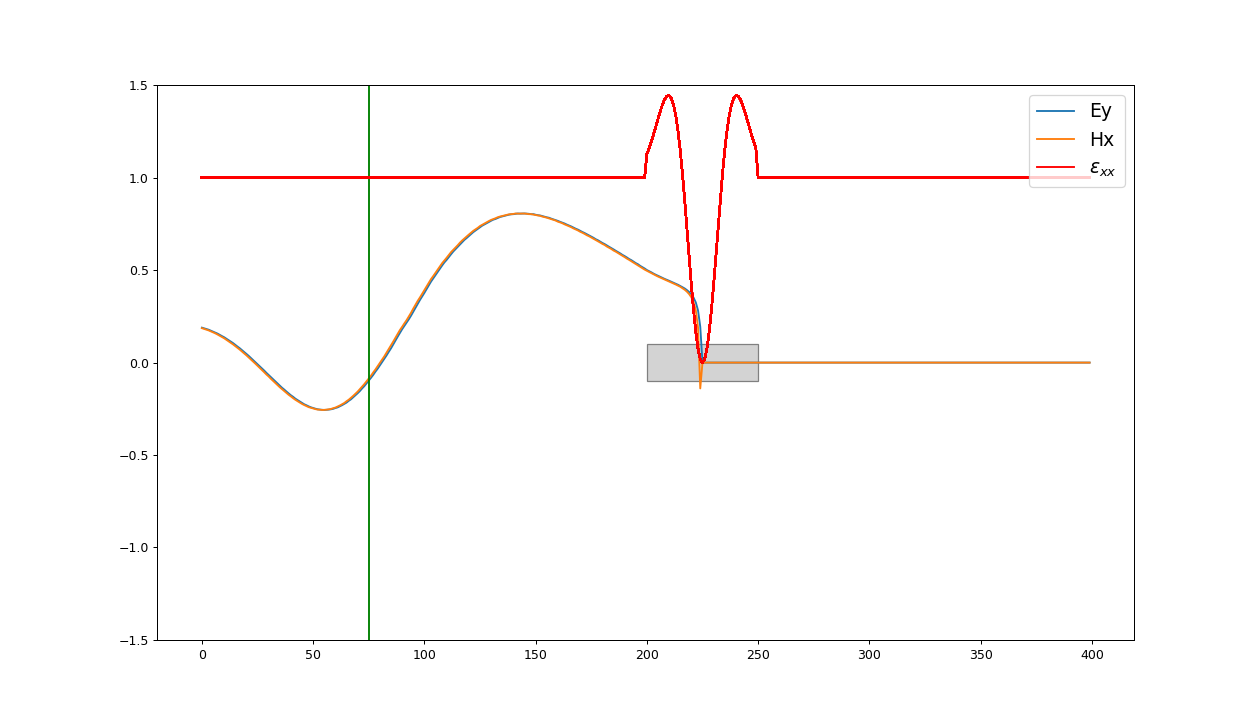

In [26]:
%matplotlib notebook

Hxtemp = [0,0,0]       # Initialise variables
Eytemp = [0,0,0]
Hxo = np.zeros(kmax+1)
Eyo = np.zeros(kmax+1)
Hx = np.zeros(kmax+1)
Ey = np.zeros(kmax+1)
#obj, = plt.plot(range(len(epsr_xx)),(epsr_xx),color ='r') # Plot red permittivity
fig, ax = plt.subplots(figsize=(14,8))  # Create figure
n = range(kmax)
ax.set_ylim(-1.5,1.5)
line1, = ax.plot(n, Ey[:-1])  # Updates E-field line
line2, = ax.plot(n, Hx[:-1])  # Updates H-field line
rectangle = plt.Rectangle((kMat,-0.1), MaterialLength, 0.2, fc='lightgrey',ec="grey") # Visual representation of material
plt.gca().add_patch(rectangle)
ax.axvline(x = ksource, color = 'g') # Source injection line

for t in range(T):    
    Eyo,Hxo,Eytemp,Hxtemp = update(Eyo,Hxo,Eytemp,Hxtemp)  # Executes update equations
    if t%5 == 0:  # Plots every 5 iterations for efficiency
        obj, = plt.plot(range(len(epsr_xx)),(epsr_xx),color ='r')  # Plot red permittivity line
        plot_func()
        